# Importing main packages

In [ ]:
Here we proceed to import our main packages;

In [1]:
import os
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

import os

!pip install biosppy
!pip install pyhrv
!pip install neurokit2
!pip install hrv
!pip install heartpy
!pip install neurokit

import heartpy
import biosppy
import neurokit2 as nk
import hrv
import pyhrv
import matplotlib.gridspec as gridspec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 KB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spectrum: filename=spectrum-0.8.1-cp39-cp39-linux_x86_64.whl size=237779 sha256=02743f81d1340cb738855dcf22ac0d971ebb31c6ddb4b01a10605cadea4d1d54
  Stored in directory: /root/.cache/pip/wheels/a0/03/05/e7ced8d2ae677d5c887dafb37619e6f0f978b2f5e60b5cd8e9
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64214 sha256=3f7f1f0208c9167aa7ec832a2dd33f633809bd0

# Warning

When loading hrv, an ImportError may arise. It will be corrected by doing the following:   
* Go to your local environment at anaconda3 and search the folder site-packages/hrv.    
* Open the file rri.py and change the following line:    
from collections import MutableMapping, defaultdict    
* by the following lines    
from collections.abc import MutableMapping    
from collections import defaultdict     

As it can be seen, we used Google Colaboratory to load the code; Kaggle Notebooks tools could have also been used. 
It must be kept in mind that this projects, without employing a GPU, lasted around 2 hours; mainly to get the features of every single signal and training the model.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preprocessing part

We aim to obtain all the signals. We have 550 signals associated to training and 250 associated to test.

(0.0, 50.0)

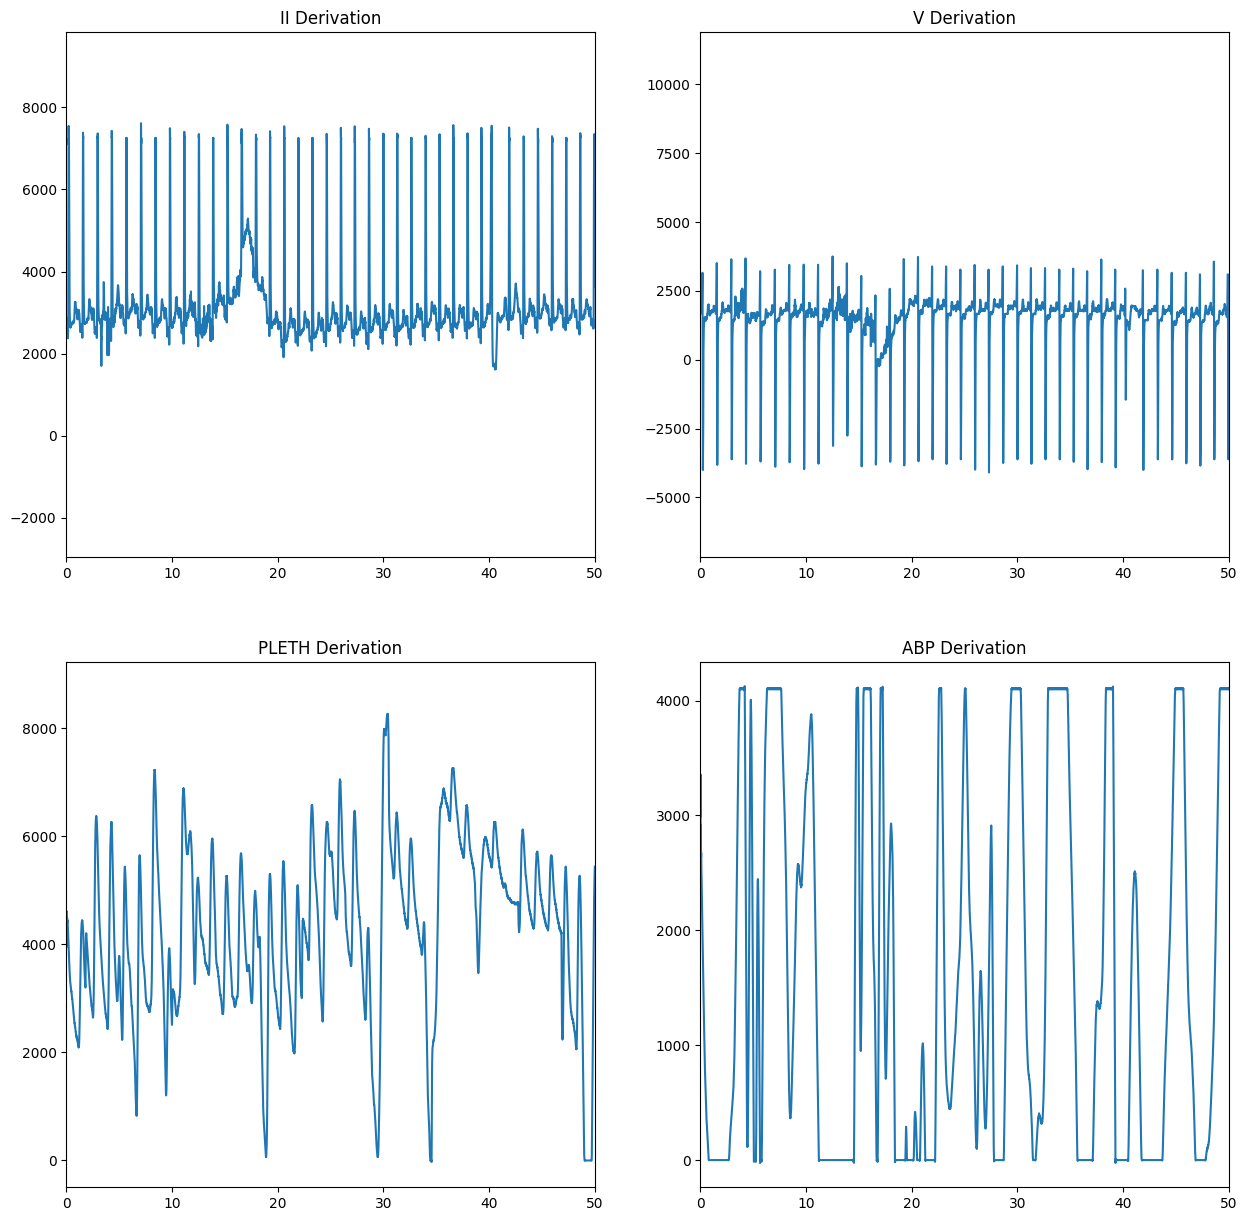

In [3]:
path = '/content/gdrive/MyDrive/physiological-signals-processing-challenge-2021/data_challenge/training/'

names_list = []
for i in range(1, 551):
    pat_filename = '{}.hea'.format(i)
    names_list.append(pat_filename)
signals_list = []
for elem in names_list:
    pat = loadmat(os.path.join(path, elem[:-4] + '.mat')) # reading the signals' file.
    signals_list.append(pat)

for elem in signals_list:
    elem = sc.signal.resample(elem['val'], 125) #resampling to 125 Hz.

#plotting a sample 
t = np.arange(0, 75000)/125
plt.figure(figsize = (15, 15))
plt.subplot(221)
plt.plot(t, signals_list[1]['val'][0,:75000])
plt.title('II Derivation')
plt.xlim(0, 50)
plt.subplot(222)
plt.plot(t, signals_list[1]['val'][1,:75000])
plt.title('V Derivation')
plt.xlim(0, 50)
plt.subplot(223)
plt.plot(t, signals_list[1]['val'][2, :75000])
plt.title('PLETH Derivation')
plt.xlim(0, 50)
plt.subplot(224)
plt.plot(t, signals_list[1]['val'][3, :75000])
plt.title('ABP Derivation')
plt.xlim(0, 50)


Now, we will proceed to filter our signal to remove typical noises.

In [4]:
# We apply a low-pass filter (IIR notch) at 50 Hz to remove streamline voltage.
b, a= sc.signal.iirnotch(38, fs = 125, Q = 30)
# We apply a pass-band filter at 0.5-40Hz to remove baseline wander (and EMG noise)
c = sc.signal.firwin(64, [0.5, 40], pass_zero = False, fs=125, window='hamming')
def getting_filtered_signals(signals_list: np.array, channel: int):
    arr = []
    for i in range (551):
        try:
            elem1 = sc.signal.filtfilt(b, a, signals_list[i]['val'][channel, :75000])
            elem1 = sc.signal.filtfilt(c, 1, elem1)
            elem1[np.isnan(elem1)] = 0.00001
            elem1 = sc.signal.detrend(elem1)
            elem1 = heartpy.enhance_peaks(elem1, iterations = 2)
            arr.append(elem1)
        except IndexError: 
            # IndexError appears as a result of the dataset; not all patients have a PLETH or ABP signal channel.
            continue
    return arr
II_filtered_list = getting_filtered_signals(signals_list, 0)
V_filtered_list = getting_filtered_signals(signals_list, 1)
ABP_filtered_list = getting_filtered_signals(signals_list, 2)
PLETH_filtered_list = getting_filtered_signals(signals_list, 3)

Now we proceed to represent the first element of each channel to see our results.

(0.0, 50.0)

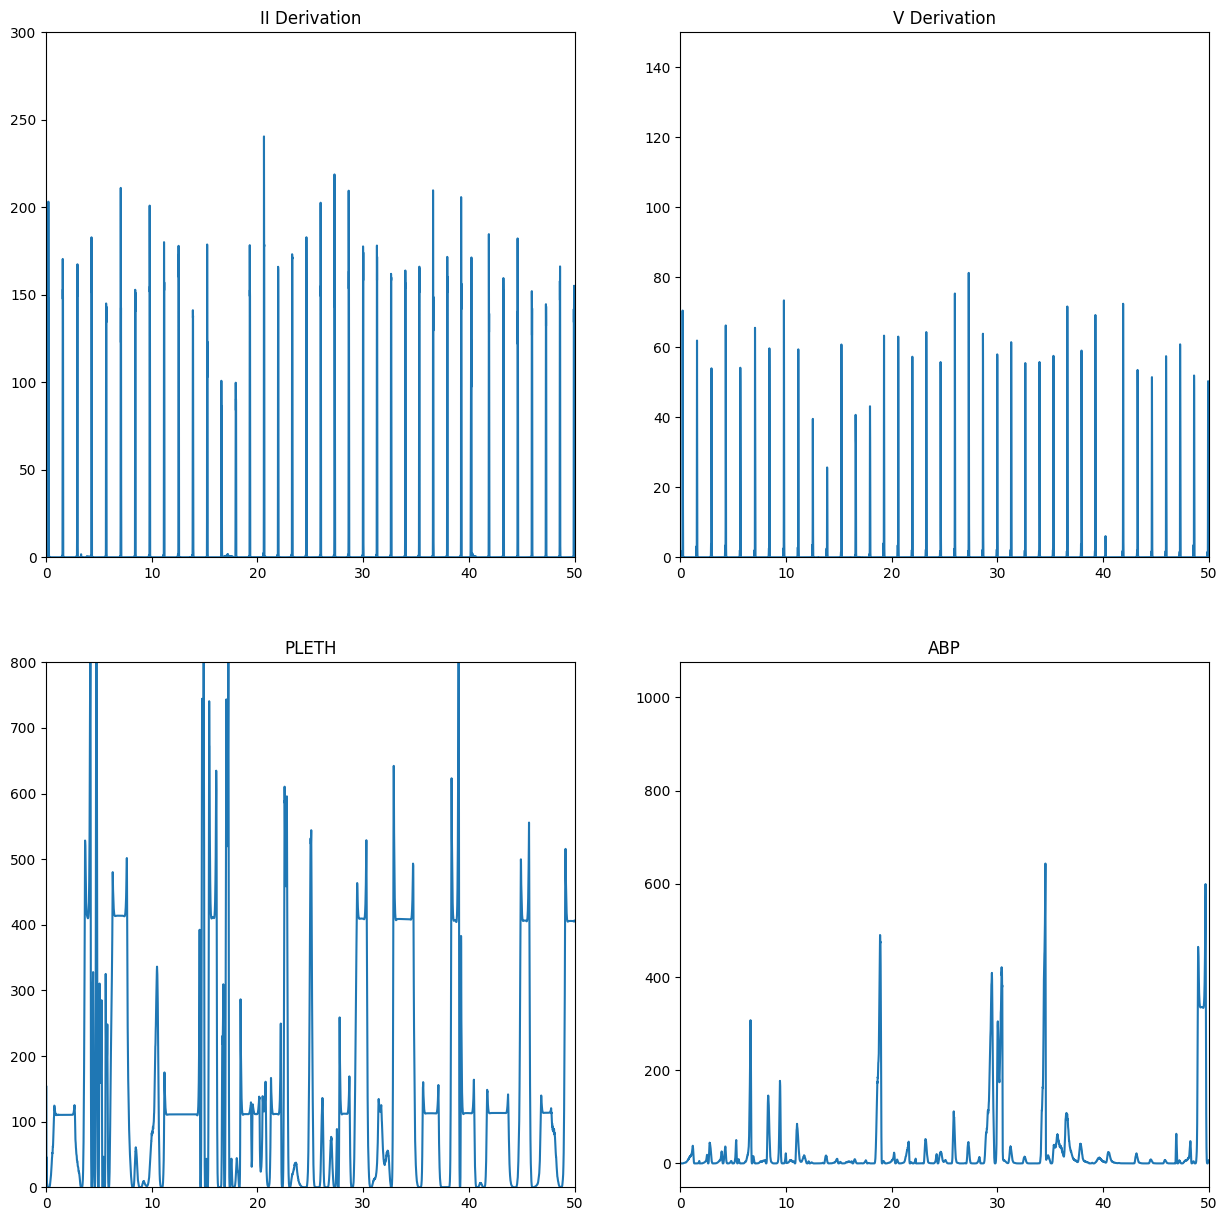

In [5]:
gs = gridspec.GridSpec(2, 2)
t = np.arange(0, 75000)/125
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.plot(t, II_filtered_list[1])
plt.title('II Derivation')
plt.xlim(0, 50)
plt.ylim(0, 300)
ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.plot(t, V_filtered_list[1])
plt.title('V Derivation')
plt.xlim(0, 50)
plt.ylim(0, 150)
ax3 = fig.add_subplot(gs[1, 0]) # row 1, col 0
ax3.plot(t, PLETH_filtered_list[1])
plt.title('PLETH')
plt.xlim(0, 50)
plt.ylim(0, 800)
ax4 = fig.add_subplot(gs[1, 1]) # row 1, col 1
ax4.plot(t, ABP_filtered_list[1])
plt.title('ABP')
plt.xlim(0, 50)

# Feature acquisition part

We are going to obtain as much features as possible about our signals with the aim of obtaining the best metrics. We will also use several approaches to get those statistics to see which one is better for our purposes.

In [6]:
def getting_properties(entry: np.array):
    rpeaks = []
    rr_interval = []
    properties = []
    for index, value in enumerate(entry):
        rpeaks_init, _ = sc.signal.find_peaks(entry[index], distance = 150)
        rpeaks_init = biosppy.signals.ecg.correct_rpeaks(entry[index], rpeaks = rpeaks_init, sampling_rate = 125, tol = 0.04)
        rr_interval_init = np.diff(rpeaks_init)/125 * 1000
        rpeaks.append(rpeaks_init[0])
        rr_interval.append(rr_interval_init)
        rpeaksV, propertiesV = sc.signal.find_peaks(entry[index], distance = 150, prominence = 1, width = 20)
        properties.append(propertiesV["width_heights"]) # width of the peak, relative to baseline; the width is 
        # normally narrower if there are more beats per second.
        return rpeaks, properties, rr_interval

In [7]:
# Obtaining R peaks of ECG signals and RR intervals.
rpeaks_V, properties_V, rr_interval_V = getting_properties(V_filtered_list)
rpeaks_II, properties_II, rr_interval_II = getting_properties(II_filtered_list)

rpeaks_V = rpeaks_V
rpeaks_II = rpeaks_II
rr_interval_II = rr_interval_II[0]
rr_interval_V = rr_interval_V[0]

In [8]:
def getting_stats_biosspy(filtered_list: list):
    average_list = []
    median_list = []
    minimum_list = []
    maximum_list = []
    max_amplitude_list = []
    quasivar_list = []
    std_list = []
    mad_list = []
    kurt_list = []
    skew_list = []
    for i in range(len(filtered_list)):
        a = biosppy.signals.tools.signal_stats(filtered_list[i])
        average = a[0]
        median = a[1]
        minimum = a[2]
        maximum = a[3]
        max_amplitude = a[4]
        quasivar = a[5]
        std = a[6]
        mad = a[7]
        kurt = a[8]
        skew = a[9]
    return average_list, median_list, minimum_list, maximum_list, max_amplitude_list, quasivar_list, std_list, mad_list, kurt_list, skew_list

averageV, medianV, minimumV, maximumV, maxamplitudeV, quasivarV, stdV, madV, kurtV, skewV = getting_stats_biosspy(V_filtered_list)
averageII, medianII, minimumII, maximumII, maxamplitudeII, quasivarII, stdII, madII, kurtII, skewII = getting_stats_biosspy(II_filtered_list)
averagePLETH, medianPLETH, minimumPLETH, maximumPLETH, maxamplitudePLETH, quasivarPLETH, stdPLETH, madPLETH, kurtPLETH, skewPLETH = getting_stats_biosspy(PLETH_filtered_list)


In [9]:
# We proceed to calculate autocorrelation.
def autocorrelation(filtered_list):
    autocor_list = []
    for i in range(len(filtered_list)):
        autocor = np.correlate(filtered_list[i], filtered_list[i])
        autocor_list.append(autocor)
    return autocor_list

autocorV = autocorrelation(V_filtered_list)
autocorII = autocorrelation(II_filtered_list)
autocorPLETH = autocorrelation(PLETH_filtered_list)
autocorABP = autocorrelation(ABP_filtered_list)


In [10]:
# Obtaining several features from PLETH.
systolic_peaks = []
for i in range(len(PLETH_filtered_list)):
    try: # Calculating the samples where we can find systolic peaks.
        systolic_peak = nk.ppg_findpeaks(PLETH_filtered_list[i], sampling_rate = 125)  
        systolic_peaks.append(systolic_peak['PPG_Peaks'][0])
        
    except IndexError: # It happens as a result of not existing enough beats (bradychardia)
        #It arises at 4, 64, 71, 289, 336 y 434.
        systolic_peaks.append(0)
# Calculating cardiac index of PLETH
heart_rate_PLETH = []
for i in range(len(systolic_peaks)):
    ppg_cardiac_rate = nk.ppg_rate(systolic_peaks[i], sampling_rate = 125)
    heart_rate_PLETH.append(ppg_cardiac_rate)

In [11]:
#Calculating max and min RR intervals.
max_int_RR_II = []
max_int_RR_V = []
for i in range(len(rr_interval_V)):
    elem = max(rr_interval_V[i])
    max_int_RR_V.append(elem)
for i in range(len(rr_interval_II)):
    elem = max(rr_interval_II[i])
    max_int_RR_II.append(elem)

In [12]:
def time_domain_statistics(rr_interval: list):
    mean_hr = []
    min_hr = []
    max_hr = []
    std_hr = []
    mean_nni_diff = []
    min_nni_diff = []
    max_nni_diff = []
    for i in range(len(rr_interval_V)):
        try:
            statistics_hr = pyhrv.time_domain.hr_parameters(nni = rr_interval[i])
            nni_differences = pyhrv.time_domain.nni_differences_parameters(nni = rr_interval[i][0])
            mean_hr.append(statistics_hr[0])
            min_hr.append(statistics_hr[1])
            max_hr.append(statistics_hr[2])
            std_hr.append(statistics_hr[3])
            mean_nni_diff.append(nni_differences['nni_diff_mean'])
            min_nni_diff.append(nni_differences['nni_diff_min'])
            max_nni_diff.append(nni_differences['nni_diff_max'])
        except: # IndexError and ValueError raises when iterating over the following sequences:
        #152, 164, 322, 324, 384, 387, 389, 498, 508
            mean_hr.append(45)
            min_hr.append(25)
            max_hr.append(51)
            std_hr.append(2)
            mean_nni_diff.append(282)
            min_nni_diff.append(0)
            max_nni_diff.append(1248)
    return mean_hr, min_hr, max_hr, std_hr, mean_nni_diff, min_nni_diff, max_nni_diff

mean_hrV, min_hrV, max_hrV, std_hrV, mean_nni_diff_V, min_nni_diff_V, max_nni_diff_V = time_domain_statistics(rr_interval_V)
mean_hrII, min_hrII, max_hrII, std_hrII,mean_nni_diff_II, min_nni_diff_II, max_nni_diff_II = time_domain_statistics(rr_interval_II)

We proceed to get more possible features using biosspy.

In [13]:
from biosppy.signals import tools as st
from biosppy.signals.ecg import hamilton_segmenter, christov_segmenter, correct_rpeaks, extract_heartbeats
from biosppy import plotting

def getting_features(ecg_filtered : list, fs: int):
    
    try:
        #R peaks
        r_peaks = hamilton_segmenter(ecg_filtered,sampling_rate = fs)
        r_peaks = np.array(r_peaks[0])
        rr_interval = np.diff(r_peaks)/fs * 1000
        mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness= st.signal_stats(rr_interval)
        min_rrinterval=np.min(rr_interval)
        
        #ECG features
        mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2= st.signal_stats(ecg_filtered)
        freq, power = st.power_spectrum(signal=ecg_filtered, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        potencia = np.mean(power)
        autocorrelacion = np.correlate(ecg_filtered, ecg_filtered)
        
    except ValueError:
        mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness=[0,0,0,0,0,0,0,0]
        mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2=[0,0,0,0,0,0,0,0]
        min_rrinterval=0
        potencia = 0
        autocorrelacion = 0

    return mean, median,maxim, var, std_dev, abs_dev, kurtosis, skewness, mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2, min_rrinterval, potencia, autocorrelacion



Analysing ABP channel using scipy.

In [14]:
from biosppy.signals.bvp import bvp 
from scipy.signal import find_peaks
def analysis_abp(abp : np.array ,fs: int):
     #mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness
        x= st.signal_stats(abp)
        std_dev = x[4]
        max_abp= x[2]
        min_abp=np.min(abp)
      
        freq, power = st.power_spectrum(signal=abp, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        mean_power = np.mean(power)

        return min_abp, max_abp, mean_power, std_dev

Analysing PLETH channel using scipy

In [15]:
def analysis_pleth(pleth: np.array , fs:int):
    #mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness
        a= st.signal_stats(pleth)
        std_dev = a[4]
        kurtosis = a[6]
        skewness = a[7]
        min_pleth=np.min(pleth)
        std_pleth = np.std(pleth)
        
        
        freq, power = st.power_spectrum(signal=pleth, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        mean_power = np.mean(power)
        autocor = np.correlate(pleth, pleth)
    
        return min_pleth,std_dev, kurtosis, skewness, mean_power, autocor, std_pleth

Another approach to get ECG stats.

In [16]:
from biosppy.signals.ecg import ecg

def get_mean_std_hr_one_pat(signals: np.array, header: list, plot_flag = True):
    ecg_lead = ['I', 'II', 'III', 'MCL','V','aVF', 'aVL','aVR']
    fs = int(header[0].split()[2])
    num_signals = int(header[0].split()[1])
    labels = []
    
    for signal in header[1:]:
        labels.append(signal.split()[-1])

    idx_ecg = [labels.index(i) for i in ecg_lead if i in labels]
   
    if plot_flag:
        plt.plot(signals[idx_ecg[0],:1000])
        print(labels[idx_ecg[0]])
    
    try:
        ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal=signals[idx_ecg[0],:], sampling_rate=fs, show=False)
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)

    
    except:
        print("Not enough beats")
        print(header[0].split()[0])
        hr = 50   
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
        templates = 0
        
    return mean_hr, std_hr, minim_hr, maxim_hr, median_hr, templates

Getting the envelope of the signals

In [17]:
import scipy.signal as sc
def envelope(ecg_filtered: list, fs: int ,dmin=1, dmax=1):
    try:    
        fn=fs/2
        #we are going to create and apply a bandstop filter.
        f_c_l = 5/fn #critical frequency of our lowpass filter
        f_c_h = 15/fn #critical frequency of our highpass filter
        b,a = sc.butter(10,f_c_h,'lowpass')
        b_h,a_h = sc.butter(7,f_c_l,'highpass')

        w, h = sc.freqz(b,a, worN =2056*20,fs = fs)
        w, h_h = sc.freqz(b_h,a_h, worN =2056*20,fs = fs)

        ecg_bp = sc.filtfilt(b,a,ecg_filtered)
        ecg_bp = sc.filtfilt(b_h,a_h,ecg_filtered)
        
        #applying a second filter.
        a = 1
        b = 1/8*np.array([2,1,0,-1,-2])
        ecg_der = sc.filtfilt(b,a,ecg_filtered)
        
        # global max of the size of signal
        lmax = (np.diff(np.sign(np.diff(ecg_filtered))) < 0).nonzero()[0] + 1 
        lmax = lmax[[i+np.argmax(ecg_filtered[lmax[i:i+1]]) for i in range(0,len(lmax),1)]]   
        
        var = np.var(lmax)
        std = np.std(lmax)
        mean = np.mean(lmax)
    except: 
        std, var, mean = [0,0,0]
        
    return var, std, mean

Another approach to getting heart_rate related statistics

In [18]:
def heart_rates(ecg_filtered: list, fs: int):
    try: 
        ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal= ecg_filtered, sampling_rate=fs, show=False)
        
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
    
    except: 
        hr = 60
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
        templates = 0
    return  minim_hr, mean_hr, std_hr, maxim_hr

# Classifier part

On this part we are going to train our Gaussian Naive Bayes model with the features we have calculated. We have trained it with those, even though it is possible that exist better combinations of some of the multiple features we got from the signals; the reader should keep in mind this project was developed on a very tight deadline.    

Most of the time, on Data Science projects, the data scientist must consider a trade-off between excel on his job and having something to present to the stakeholders or, as it was our case, to the competition.

-------------------------------------------------------------

On this cell, we get our training array.    
We finally used the second approaches to get our X array even though the first approaches could have been used too.   
Besides, we decided to use mostly the II channel to get our results from.   
For the sake of time and given that it was a 1-month competition, we could not take into consideration all the possible circumstances.   

II
III
II
II
II
II
II
II
II
II
II
Not enough beats
108
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
123
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
153
II
II
II
II
II
III
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
213
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
235
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
II
II
III
II
II
II
II
II
II
II
III
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
I
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
304
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
337
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I

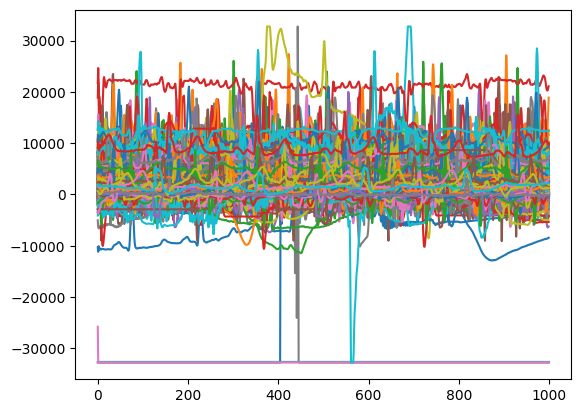

In [19]:
#getting our training array
X = []

for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/physiological-signals-processing-challenge-2021/data_challenge/training/'):
    filenames.sort()
    j = 0
    for filename in filenames[:]:      
            
        if 'mat' in filename:
            continue
        j+=1
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()
                
        fs = int(header[0].split()[2]) #sampling frequency

        signals = record['val']     
        labels = []
        for i in header[1:]:
            #split the string and get the last (the label)
            labels.append(i.split()[-1])
         
        for i in range(len(labels)): 
            #getting apb and pleth features
            if labels[i] == 'PLETH':
                min_pleth,std_dev_pleth, kurtosis_pleth, skewness_pleth, power_pleth, autocorr_pleth, std_pleth=analysis_pleth(signals[i,:],fs)
                
            elif labels[i] == 'ABP':
                min_abp, max_abp, power_abp, std_dev_abp = analysis_abp(signals[i,:], fs)
            
            else: #some signals, as said before, do not have abp or pleth channels; we take care of this situations.
                min_pleth,std_dev_pleth, kurtosis_pleth, skewness_pleth, power_pleth, autocorr_pleth, std_pleth = [0,0,0,0,0,0,0]
                min_abp, max_abp, power_abp, autocorr_abp, std_peaks_abp, std_dev_abp = [0,0,0,0,0,0]
                
        
        meanV, medianV,maximV, varV, std_devV, abs_devV, kurtosisV, skewnessV, mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2, min_rrinterval, potencia, autocorrelacion=getting_features(II_filtered_list, fs)
        minim_hr1, mean_hr, std_hr1, maxim_hr1 = heart_rates(II_filtered_list, fs)        
        var_envolsup, std_envolsup, mean_envolsup = envelope(II_filtered_list,fs)
        mean_hr, std_hr, minim_hr, maxim_hr, median_hr, templates = get_mean_std_hr_one_pat(signals,header,plot_flag = True)
        
        
        X.append([int(filename[:-4]),std_hr, min_rrinterval, maxim_hr, minim_hr, min_pleth])

#Matrix X
X = np.array(X)
X = np.nan_to_num(X)  

In [20]:
# Creating naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score

# Getting our labels
y = np.loadtxt('/content/gdrive/MyDrive/physiological-signals-processing-challenge-2021/alarms_training.csv',skiprows=1,delimiter = ',',usecols = [0,1])
y_train = y[np.array(X[:,0]-1,dtype = int),:]

# Getting our priors

P_h0 = np.mean(y_train[:,1] == 0)
P_h1 = np.mean(y_train[:,1] == 1)

print('P_h0:',P_h0,'; P_h1:',P_h1)


nb_detector = GaussianNB(priors = [P_h0,P_h1])

# Training our model
nb_detector.fit(X[:,1:],y_train[:,1])

P_h0: 0.6145454545454545 ; P_h1: 0.38545454545454544


GaussianNB(priors=[0.6145454545454545, 0.38545454545454544])

Creating our "test" file to be delivered to the competition. This test file is actually a validation file,
given that the competition has its own test files to create the private leaderboard.

II
III
II
II
II
II
II
II
II
II
II
Not enough beats
108
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
123
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
153
II
II
II
II
II
III
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
213
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
235
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
II
II
III
II
II
II
II
II
II
II
III
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I
II
II
I
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
304
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
Not enough beats
337
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
II
I

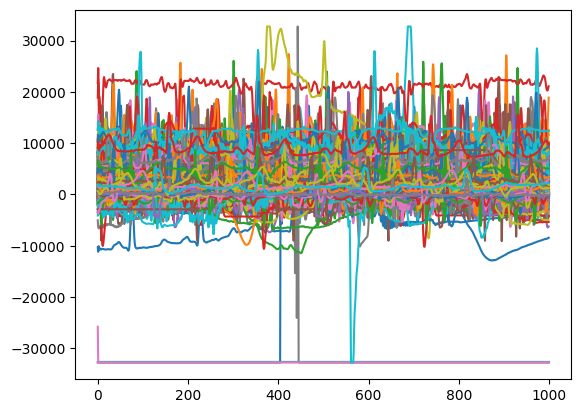

In [21]:
#getting our test array
X_test = []

for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/physiological-signals-processing-challenge-2021/data_challenge/training/'):
    filenames.sort()
    j = 0
    for filename in filenames[:]:      
            
        if 'mat' in filename:
            continue
        j+=1
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()
                
        fs = int(header[0].split()[2]) #sampling frequency

        signals = record['val']     
        labels = []
        for i in header[1:]:
            #split the string and get the last (the label)
            labels.append(i.split()[-1])
         
        for i in range(len(labels)): 
            #getting apb and pleth features
            if labels[i] == 'PLETH':
                min_pleth,std_dev_pleth, kurtosis_pleth, skewness_pleth, power_pleth, autocorr_pleth, std_pleth=analysis_pleth(signals[i,:],fs)
                
            elif labels[i] == 'ABP':
                min_abp, max_abp, power_abp, std_dev_abp = analysis_abp(signals[i,:], fs)
            
            else: #some signals, as said before, do not have abp or pleth channels; we take care of this situations.
                min_pleth,std_dev_pleth, kurtosis_pleth, skewness_pleth, power_pleth, autocorr_pleth, std_pleth = [0,0,0,0,0,0,0]
                min_abp, max_abp, power_abp, autocorr_abp, std_peaks_abp, std_dev_abp = [0,0,0,0,0,0]
                
        
        meanV, medianV,maximV, varV, std_devV, abs_devV, kurtosisV, skewnessV, mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2, min_rrinterval, potencia, autocorrelacion=getting_features(II_filtered_list, fs)
        minim_hr1, mean_hr, std_hr1, maxim_hr1 = heart_rates(II_filtered_list, fs)        
        var_envolsup, std_envolsup, mean_envolsup = envelope(II_filtered_list,fs)
        mean_hr, std_hr, minim_hr, maxim_hr, median_hr, templates = get_mean_std_hr_one_pat(signals,header,plot_flag = True)
        
        
        X_test.append([int(filename[:-4]),std_hr, min_rrinterval, maxim_hr, minim_hr, min_pleth])

In [22]:
# sorting our data
X_test = np.array(X_test)
print(X_test[:3,:])
idx_sort = np.argsort(X_test[:,0])

X_test = X_test[idx_sort,:]

print(X_test[:3,:])

[[1.00000000e+00 3.87796479e+00 0.00000000e+00 1.30249455e+02
  8.58534988e+01 0.00000000e+00]
 [1.00000000e+01 1.67987288e+01 0.00000000e+00 1.78841991e+02
  6.00707427e+01 1.14000000e+03]
 [1.00000000e+02 2.13493079e+01 0.00000000e+00 1.67786918e+02
  6.05160261e+01 1.24680000e+04]]
[[  1.           3.87796479   0.         130.24945485  85.85349882
    0.        ]
 [  2.          25.89989852   0.         173.46297073  71.00123181
    0.        ]
 [  3.          18.5064383    0.         143.78178456  79.57725564
    0.        ]]


In [24]:
#generating our solution to be submitted to the competition.

import pandas as pd
y_hat_test = nb_detector.predict(X_test[:,1:])
df = pd.DataFrame({'Id': X_test[:,0], 'Category': y_hat_test})

df.to_csv('submission_naive_bayes.csv',index = False)